In [3]:
import ezdxf
import argparse
import math
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def read_cad_file(file_path):
    """Read DWG or DXF file and extract 2D entities."""
    try:
        # Get file extension
        ext = os.path.splitext(file_path)[1].lower()

        if ext == ".dxf":
            doc = ezdxf.readfile(file_path)
            print(f"Successfully opened {ext.upper()} file: {file_path}")

            # Get the model space
            msp = doc.modelspace()

            # Extract line, arc, circle, polyline entities
            entities = []
            for entity in msp:
                if entity.dxftype() in ["LINE", "ARC", "CIRCLE", "LWPOLYLINE", "POLYLINE", "SPLINE"]:
                    entities.append(entity)

            print(f"Found {len(entities)} 2D entities in the file")
            return entities
        else:
            print(f"Unsupported file format: {ext}")
            return None
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

In [5]:
entities = read_cad_file("ailerons.dxf")
# entities = read_cad_file("leading_edge.dxf")
entities

Successfully opened .DXF file: ailerons.dxf
Found 14 2D entities in the file


[<class 'ezdxf.entities.line.Line'> LINE(#77),
 <class 'ezdxf.entities.spline.Spline'> SPLINE(#78),
 <class 'ezdxf.entities.arc.Arc'> ARC(#79),
 <class 'ezdxf.entities.line.Line'> LINE(#7A),
 <class 'ezdxf.entities.arc.Arc'> ARC(#7B),
 <class 'ezdxf.entities.line.Line'> LINE(#7C),
 <class 'ezdxf.entities.line.Line'> LINE(#81),
 <class 'ezdxf.entities.spline.Spline'> SPLINE(#82),
 <class 'ezdxf.entities.arc.Arc'> ARC(#83),
 <class 'ezdxf.entities.line.Line'> LINE(#84),
 <class 'ezdxf.entities.arc.Arc'> ARC(#85),
 <class 'ezdxf.entities.line.Line'> LINE(#86),
 <class 'ezdxf.entities.line.Line'> LINE(#8E),
 <class 'ezdxf.entities.line.Line'> LINE(#93)]

In [6]:
def entity_to_points(entity, scale=1.0, points_per_arc=50):
    """Convert a DXF entity to a list of points."""
    points = []

    if entity.dxftype() == "LINE":
        # Line is just start and end points
        points.append((entity.dxf.start.x * scale, entity.dxf.start.y * scale))
        points.append((entity.dxf.end.x * scale, entity.dxf.end.y * scale))

    elif entity.dxftype() == "CIRCLE":
        # Convert circle to a series of points
        center = entity.dxf.center
        radius = entity.dxf.radius * scale

        for i in range(points_per_arc + 1):
            angle = i * 2 * math.pi / points_per_arc
            x = center.x + radius * math.cos(angle)
            y = center.y + radius * math.sin(angle)
            points.append((x * scale, y * scale))

    elif entity.dxftype() == "ARC":
        # Convert arc to a series of points
        center = entity.dxf.center
        radius = entity.dxf.radius * scale
        start_angle = math.radians(entity.dxf.start_angle)
        end_angle = math.radians(entity.dxf.end_angle)

        # Handle cases where end_angle < start_angle (crosses 0°)
        if end_angle < start_angle:
            end_angle += 2 * math.pi

        angle_span = end_angle - start_angle
        num_points = max(2, int(points_per_arc * angle_span / (2 * math.pi)))

        for i in range(num_points + 1):
            angle = start_angle + i * angle_span / num_points
            x = center.x + radius * math.cos(angle)
            y = center.y + radius * math.sin(angle)
            points.append((x * scale, y * scale))
    
    elif entity.dxftype() == "SPLINE":
        try:
            # Try using the construction_tool() method if available
            if hasattr(entity, 'construction_tool'):
                try:
                    bspline = entity.construction_tool()
                    t_values = np.linspace(0, 1, points_per_arc * 2)
                    curve_points = [bspline.point(t) for t in t_values]
                    
                    for point in curve_points:
                        points.append((point[0] * scale, point[1] * scale))
                except Exception as e:
                    print(f"Error using construction_tool for SPLINE: {e}")
                    # If construction_tool fails, we'll use control points as a fallback
                    pass
            
            # If we couldn't get points using construction_tool, use control points
            if not points and hasattr(entity, 'control_points'):
                control_points = entity.control_points
                # For a simple approach, use linear interpolation between control points
                for i in range(len(control_points) - 1):
                    p1 = control_points[i]
                    p2 = control_points[i + 1]
                    for t in range(points_per_arc + 1):
                        alpha = t / points_per_arc
                        x = p1[0] * (1 - alpha) + p2[0] * alpha
                        y = p1[1] * (1 - alpha) + p2[1] * alpha
                        points.append((x * scale, y * scale))
        except Exception as e:
            print(f"Error processing SPLINE entity: {e}")

    elif entity.dxftype() in ["LWPOLYLINE", "POLYLINE"]:
        # For polylines, get all vertices
        if entity.dxftype() == "LWPOLYLINE":
            for vertex in entity.vertices():
                points.append((vertex[0] * scale, vertex[1] * scale))
        else:  # Regular POLYLINE
            for vertex in entity.vertices():
                points.append((vertex.dxf.location.x * scale, vertex.dxf.location.y * scale))

        # Close the loop if polyline is closed
        if hasattr(entity, "dxf") and hasattr(entity.dxf, "closed") and entity.dxf.closed:
            points.append(points[0])  # Add the first point to close the loop

    return points

In [7]:
def plot_entities(entities, ax=None, show=True):
    """
    Plot DXF entities (lines, arcs, circles, polylines, splines) from ezdxf.
    
    Args:
        entities: List of ezdxf entities
        ax: Matplotlib axis (optional)
        show: Whether to display the plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Define colors for different entity types with a colormap
    colors = {
        'LINE': '#1f77b4',      # blue
        'ARC': '#ff7f0e',       # orange
        'CIRCLE': '#2ca02c',    # green
        'LWPOLYLINE': '#d62728', # red
        'POLYLINE': '#9467bd',  # purple
        'SPLINE': '#8c564b',    # brown
    }

    # Set aspect ratio to equal for proper circle display
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)

    # Track legend entries we've added
    legend_entries = set()
    legend_handles = []

    # Plot each entity
    for i, entity in enumerate(entities):
        entity_type = entity.dxftype()
        color = colors.get(entity_type, 'black')

        # Add to legend if we haven't added this type yet
        label = None
        if entity_type not in legend_entries:
            label = entity_type
            legend_entries.add(entity_type)

        if entity_type == "LINE":
            x1, y1 = entity.dxf.start.x, entity.dxf.start.y
            x2, y2 = entity.dxf.end.x, entity.dxf.end.y
            line, = ax.plot([x1, x2], [y1, y2], color=color, linewidth=2, label=label)

            # Add start/end markers to the line
            ax.scatter([x1], [y1], color=color, s=20, marker='o')  # Start point
            ax.scatter([x2], [y2], color=color, s=20, marker='x')  # End point

            # Add index number near the middle of the line
            ax.text((x1 + x2) / 2, (y1 + y2) / 2, str(i), 
                    fontsize=9, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.7, pad=1, boxstyle='round'))

            if label:
                legend_handles.append(line)

        elif entity_type == "ARC":
            center = entity.dxf.center
            radius = entity.dxf.radius
            start_angle = math.radians(entity.dxf.start_angle)
            end_angle = math.radians(entity.dxf.end_angle)

            # Handle case where end angle < start angle (crosses 0°)
            if end_angle < start_angle:
                end_angle += 2 * math.pi

            # Generate points along the arc
            theta = np.linspace(start_angle, end_angle, 100)
            x = center.x + radius * np.cos(theta)
            y = center.y + radius * np.sin(theta)

            line, = ax.plot(x, y, color=color, linewidth=2, label=label)

            # Add center point and start/end markers
            ax.scatter(center.x, center.y, color=color, s=15, alpha=0.5)
            ax.scatter(center.x + radius * np.cos(start_angle), 
                       center.y + radius * np.sin(start_angle), 
                       color=color, s=20, marker='o')  # Start point
            ax.scatter(center.x + radius * np.cos(end_angle), 
                       center.y + radius * np.sin(end_angle), 
                       color=color, s=20, marker='x')  # End point

            # Add index number near the middle of the arc
            mid_angle = (start_angle + end_angle) / 2
            mid_x = center.x + radius * 1.1 * np.cos(mid_angle)
            mid_y = center.y + radius * 1.1 * np.sin(mid_angle)
            ax.text(mid_x, mid_y, str(i), 
                    fontsize=9, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.7, pad=1, boxstyle='round'))

            if label:
                legend_handles.append(line)

        elif entity_type == "CIRCLE":
            points = entity_to_points(entity, scale=1.0, points_per_arc=50)
            x = [p[0] for p in points]
            y = [p[1] for p in points]
            
            line, = ax.plot(x, y, color=color, linewidth=2, label=label)

            # Add center point
            ax.scatter(center.x, center.y, color=color, s=15)

            # Add index number
            ax.text(center.x, center.y, str(i), 
                    fontsize=9, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.7, pad=1, boxstyle='round'))

            if label:
                legend_handles.append(line)

        elif entity_type == "SPLINE":
            try:
                curve_points = entity_to_points(entity, scale=1.0, points_per_arc=50)
                # Plot the curve points
                if curve_points:
                    if isinstance(curve_points, list):
                        curve_x = [p[0] for p in curve_points]
                        curve_y = [p[1] for p in curve_points]
                    else:  # NumPy array
                        curve_x = curve_points[:, 0]
                        curve_y = curve_points[:, 1]

                    line, = ax.plot(curve_x, curve_y, color=color, linewidth=2, label=label)

                    # Add start/end markers
                    ax.scatter(curve_x[0], curve_y[0], color=color, s=20, marker='o')  # Start point
                    ax.scatter(curve_x[-1], curve_y[-1], color=color, s=20, marker='x')  # End point

                    # Add index number near the middle of the spline
                    middle_idx = len(curve_x) // 2
                    ax.text(curve_x[middle_idx], curve_y[middle_idx], str(i), 
                            fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='white', alpha=0.7, pad=1, boxstyle='round'))

                    if label:
                        legend_handles.append(line)
                else:
                    print(f"Could not calculate curve points for SPLINE entity {i}")

            except Exception as e:
                print(f"Error plotting SPLINE entity {i}: {str(e)}")

        elif entity_type in ["LWPOLYLINE", "POLYLINE"]:
            points = entity_to_points(entity, scale=1.0, points_per_arc=50)            
            if points:
                # Convert to numpy arrays for easier plotting
                points = np.array(points)
                x, y = points[:, 0], points[:, 1]

                # Close the loop if polyline is closed
                is_closed = False
                if hasattr(entity, "is_closed") and entity.is_closed:
                    is_closed = True
                    x = np.append(x, x[0])
                    y = np.append(y, y[0])

                line, = ax.plot(x, y, color=color, linewidth=2, label=label)

                # Add vertices as points
                ax.scatter(points[:, 0], points[:, 1], color=color, s=20)

                # Add index number near the middle of the polyline
                middle_idx = len(points) // 2
                ax.text(points[middle_idx, 0], points[middle_idx, 1], str(i), 
                        fontsize=9, ha='center', va='center',
                        bbox=dict(facecolor='white', alpha=0.7, pad=1, boxstyle='round'))

                if label:
                    legend_handles.append(line)

    # Add legend
    if legend_handles:
        ax.legend(handles=legend_handles, loc='upper right')

    # Set title and labels
    ax.set_title(f"DXF Entities: {len(entities)} objects")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    if show:
        plt.tight_layout()
        plt.show()

    # return ax


In [8]:
def manual_order_path(entities, order, scale=1.0):
    """
    Manually define the order in which entities should be cut, and create a flattened path.
    First path goes left to right, subsequent paths start from the end closest to the previous path's end.
    
    Args:
        entities: List of entities to be ordered
        order: List of indices specifying the desired cutting order
        scale: Scale factor for the points
    
    Returns:
        Flattened list of points representing the complete path
    """
    if not entities:
        return []
        
    # Validate order
    if not all(0 <= idx < len(entities) for idx in order):
        raise ValueError(f"Invalid entity index in order. Order must contain indices between 0 and {len(entities)-1}")

    # Convert all entities to point lists
    all_paths = []
    for idx in order:
        path = entity_to_points(entities[idx], scale)
        if path:  # Only include non-empty paths
            all_paths.append(path)
            
    if not all_paths:
        return []
    
    # Process the first path - ensure left to right
    first_path = all_paths[0]
    # Determine if first path needs reversal (left-to-right means start_x < end_x)
    if first_path[0][0] > first_path[-1][0]:
        first_path = first_path[::-1]  # Reverse points
        
    flattened_path = first_path
    prev_end_point = first_path[-1]
    
    # Process remaining paths
    for path in all_paths[1:]:
        start_point = path[0]
        end_point = path[-1]
        
        # Calculate distances from previous end to both ends of current path
        dist_to_start = ((prev_end_point[0] - start_point[0]) ** 2 + 
                        (prev_end_point[1] - start_point[1]) ** 2) ** 0.5
        dist_to_end = ((prev_end_point[0] - end_point[0]) ** 2 + 
                        (prev_end_point[1] - end_point[1]) ** 2) ** 0.5
        
        # If end is closer to previous end than start, reverse the points
        if dist_to_end < dist_to_start:
            path = path[::-1]
            
        # Extend the flattened path with this path
        flattened_path.extend(path)
        
        # Update previous end point to the last point in this path
        prev_end_point = path[-1]
    
    return flattened_path

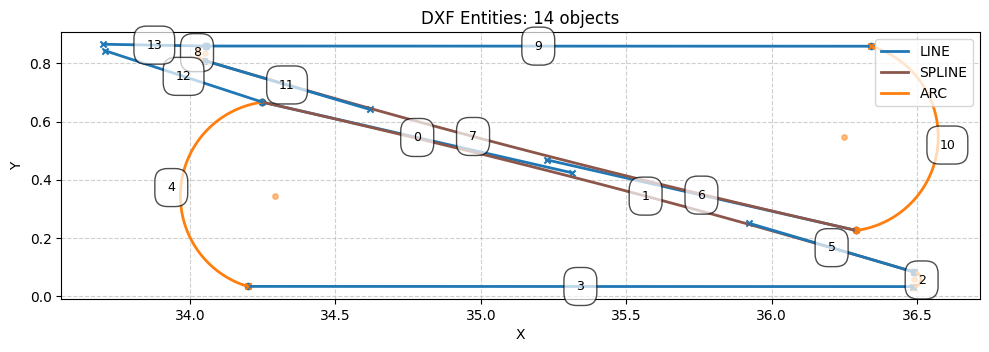

In [9]:
# Call the function to plot your entities
plot_entities(entities)

In [ ]:
order = [13, 9, 10, 7, 8, 13, 12, 1, 2, 3, 4, 12]  # Control surfaces
# order = [2, 1, 0, 2] # Leading edge
points = manual_order_path(entities, order)
points = np.array(points)
points = points * 25.4  # Convert from inches to mm

In [33]:
points[:, 0] -= points[:, 0].min()  # Shift to start at x=0 
points[:, 0] -= 5

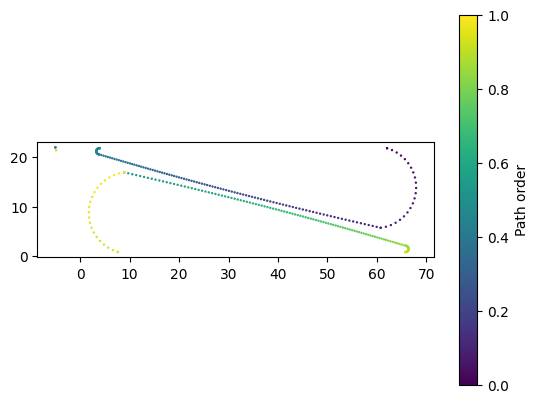

In [ ]:
plt.scatter(*zip(*points), c=np.linspace(0, 1, len(points)), cmap="viridis", s=0.5)
plt.colorbar(label="Path order")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel("Y (mm)")
plt.xlabel("X (mm)")
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from IPython.display import HTML

def animate_tool_path(points, tool_speed=1.0, tool_size=0.25, fps=30):
    """
    Create an animation of the tool movement along the path with constant speed.
    Optimized for performance.
    
    Args:
        points: List of (x, y) tuples representing the ordered path
        tool_speed: Speed of the tool in units per second
        tool_size: Size of the circular tool in the animation
        fps: Frames per second for the animation
    """
    # Convert points to numpy arrays for faster operations
    points = np.array(points)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Set limits with a small margin around the data
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
    
    margin = max((x_max - x_min), (y_max - y_min)) * 0.05
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    ax.set_aspect('equal')
    
    # Plot the complete path once (light gray)
    path_line, = ax.plot(points[:, 0], points[:, 1], 'lightgray', linewidth=1, alpha=0.5)
    
    # Initialize the "tool" as a circle
    tool = patches.Circle((points[0][0], points[0][1]), tool_size, color='red', zorder=10)
    ax.add_patch(tool)
    
    # Line for the traveled path (stronger color)
    traveled_line, = ax.plot([], [], 'blue', linewidth=2)
    
    # Text for progress indication
    progress_text = ax.text(0.02, 0.98, "Progress: 0%", 
                           transform=ax.transAxes, fontsize=12, 
                           verticalalignment='top')

    ax.set_title("Cutting Tool Path Animation")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    
    # Precompute path information - this is a major optimization
    segment_vectors = points[1:] - points[:-1]
    segment_lengths = np.linalg.norm(segment_vectors, axis=1)
    cumulative_distances = np.cumsum(np.insert(segment_lengths, 0, 0))
    total_length = cumulative_distances[-1]
    
    # Calculate total animation time and frames
    total_time = total_length / tool_speed
    num_frames = int(total_time * fps)
    interval = 1000 / fps  # Interval in milliseconds

    # Pre-compute all frame positions to avoid recalculation
    frame_positions = []
    frame_traveled_indices = []
    
    for frame in range(num_frames + 1):
        time = frame / fps
        distance = min(time * tool_speed, total_length)
        
        # Binary search to find the segment (faster than linear search for long paths)
        segment_idx = np.searchsorted(cumulative_distances, distance, side='right') - 1
        segment_idx = max(0, min(segment_idx, len(segment_lengths) - 1))
        
        # How far along this segment
        segment_start_dist = cumulative_distances[segment_idx]
        segment_progress = 0
        if segment_lengths[segment_idx] > 0:
            segment_progress = (distance - segment_start_dist) / segment_lengths[segment_idx]
        
        # Calculate position
        if segment_idx < len(segment_vectors):
            current_pos = points[segment_idx] + segment_progress * segment_vectors[segment_idx]
        else:
            current_pos = points[-1]
            
        frame_positions.append(current_pos)
        frame_traveled_indices.append(segment_idx)
    
    # Pre-allocate the arrays for traveled path
    max_traveled_points = len(points)
    traveled_x = np.zeros(max_traveled_points)
    traveled_y = np.zeros(max_traveled_points)
        
    def init():
        tool.center = (points[0][0], points[0][1])
        traveled_line.set_data([], [])
        progress_text.set_text("Progress: 0%")
        return tool, traveled_line, progress_text
    
    def update(frame):
        # Use pre-computed positions
        if frame >= len(frame_positions):
            frame = len(frame_positions) - 1
            
        current_pos = frame_positions[frame]
        segment_idx = frame_traveled_indices[frame]
        
        # Update tool position
        tool.center = (current_pos[0], current_pos[1])
        
        # Optimize traveled path update - only include points up to current segment
        if segment_idx >= len(points) - 1:  # We're at the end
            traveled_line.set_data(points[:, 0], points[:, 1])
        else:
            # Include all complete segments plus partial segment
            traveled_pts = segment_idx + 2  # +2 because we include start, all intermediate, and current
            
            # Set the traveled path data without recreating arrays
            traveled_line.set_data(
                np.append(points[:segment_idx+1, 0], current_pos[0]),
                np.append(points[:segment_idx+1, 1], current_pos[1])
            )
        
        # Update progress text
        time = frame / fps
        distance = time * tool_speed
        progress = min(100, (distance / total_length) * 100)
        progress_text.set_text(f"Progress: {progress:.1f}%")
        
        return tool, traveled_line, progress_text
    
    ani = FuncAnimation(fig, update, frames=min(num_frames, 300),  # Limit frames for better performance
                        init_func=init, blit=True, interval=interval)
    
    plt.close()  # This prevents the static plot from displaying
    return ani

In [45]:
ani = animate_tool_path(points, tool_speed=100, tool_size=0.5, fps=10)
HTML(ani.to_jshtml())

In [47]:
def generate_gcode(points, feed_rate=200.0, wire_current=1000):
    """Generate G-code from a list of points."""
    gcode = []

    # Header
    gcode.append("; Generated G-code for 4-axis hot wire cutter")
    gcode.append("; 2D profile cutting mode - left and right sides move together")
    gcode.append("")
    gcode.append("G17 ; XY plane")
    gcode.append("G21 ; Set units to millimeters")
    gcode.append("G90 ; Use absolute positioning")
    gcode.append("G40 ; Cutter compensation off")
    gcode.append("G49 ; Tool length offset compensation off")
    gcode.append("G64 ; Path Control Mode - Continuous mode")
    gcode.append("G94 ; Set feed rate")
    gcode.append(f"G{feed_rate} ; mm/min")
    gcode.append(f"M3 S{wire_current} ; Set wire current")
    gcode.append("G4 P2 ; Wait 2 seconds for wire to heat up")
    gcode.append("")

    # Move to the first point (rapid positioning)
    first_point = points[0]
    gcode.append(f"G0 X{first_point[0]:.3f} Y{first_point[1]:.3f} A{first_point[0]:.3f} Z{first_point[1]:.3f}; Rapid move to start position")

    # Add points for cutting (linear interpolation)
    for point in points[1:]:
        gcode.append(f"G1 X{point[0]:.3f} Y{point[1]:.3f} A{point[0]:.3f} Z{point[1]:.3f}")

    # Footer
    gcode.append("")
    gcode.append("M5 ; Turn off wire heater")
    gcode.append("M2 ; End program")

    return gcode

In [48]:
def write_gcode_file(gcode, output_file):
    """Write G-code to file."""
    try:
        with open(output_file, "w") as f:
            for line in gcode:
                f.write(line + "\n")
        print(f"G-code successfully written to: {output_file}")
        return True
    except Exception as e:
        print(f"Error writing G-code file: {e}")
        return False

In [ ]:
gcode = generate_gcode(points)

# Write G-code to output file
write_gcode_file(gcode, 'ailerons.ngc')
# write_gcode_file(gcode, "leading_edge.ngc")

G-code successfully written to: ailerons.ngc


True